# Feature Selection and PCA Analysis - Video Games Dataset

This notebook demonstrates feature selection techniques and Principal Component Analysis (PCA) on a video games sales dataset.

## Objectives:
1. Compare different feature selection methods
2. Apply PCA for dimensionality reduction
3. Evaluate performance of both approaches
4. Visualize results and insights

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Preparation

In [2]:

sampled_data = pd.read_csv('sampled_video_games.csv')
print(f"Dataset size: {sampled_data.shape}")

print("\nDataset info:")
print(sampled_data.info())

print("\nFirst 5 rows:")
sampled_data.head()

Dataset size: (2000, 16)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             2000 non-null   object 
 1   Platform         2000 non-null   object 
 2   Year_of_Release  1965 non-null   float64
 3   Genre            2000 non-null   object 
 4   Publisher        1991 non-null   object 
 5   NA_Sales         2000 non-null   float64
 6   EU_Sales         2000 non-null   float64
 7   JP_Sales         2000 non-null   float64
 8   Other_Sales      2000 non-null   float64
 9   Global_Sales     2000 non-null   float64
 10  Critic_Score     999 non-null    float64
 11  Critic_Count     999 non-null    float64
 12  User_Score       1231 non-null   object 
 13  User_Count       920 non-null    float64
 14  Developer        1235 non-null   object 
 15  Rating           1222 non-null   object 
dtypes: float64(9), objec

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Shitsuji ga Aruji o Erabu Toki,PSV,2016.0,Adventure,Unknown,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,Retro Atari Classics,DS,2005.0,Misc,Atari,0.12,0.00,0.00,0.01,0.13,51.0,17.0,3.7,7.0,Taniko,E
2,Blood Bowl,X360,2009.0,Sports,Focus Home Interactive,0.13,0.02,0.00,0.01,0.16,61.0,28.0,5.1,19.0,Cyanide,T
3,Little League World Series Baseball 2009,Wii,2009.0,Sports,Activision,0.14,0.00,0.00,0.01,0.15,NaN,NaN,tbd,NaN,Now Production,E
4,Pipe Mania,PSP,2008.0,Puzzle,Empire Interactive,0.06,0.00,0.00,0.01,0.07,74.0,6.0,tbd,NaN,Empire Interactive,E


In [3]:

missing_values = sampled_data.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0])

numerical_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                     'Year_of_Release', 'Critic_Score', 'User_Count', 'Critic_Count']

print(f"\nSelected numerical features: {numerical_features}")

Missing values:
Year_of_Release      35
Publisher             9
Critic_Score       1001
Critic_Count       1001
User_Score          769
User_Count         1080
Developer           765
Rating              778
dtype: int64

Selected numerical features: ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Year_of_Release', 'Critic_Score', 'User_Count', 'Critic_Count']


## 3. Create Target Variable

Global Sales median: 0.17 million

Class distribution:
  Class 0: 1014 samples (50.7%)
  Class 1: 986 samples (49.3%)


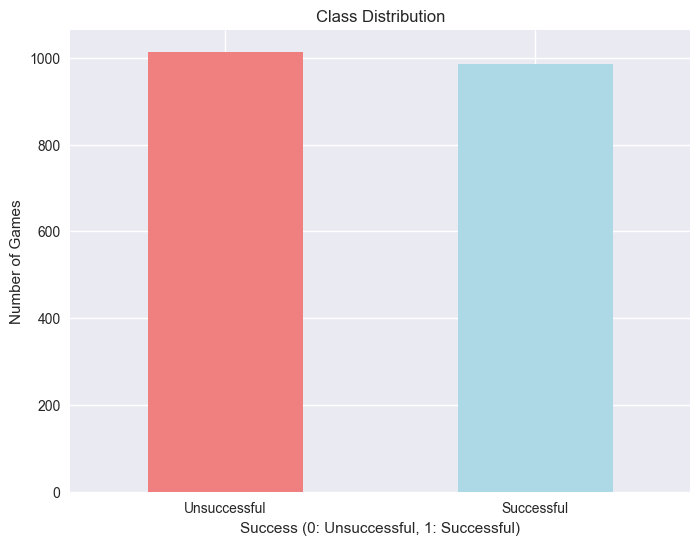

In [4]:

median_sales = sampled_data['Global_Sales'].median()
sampled_data['Success'] = (sampled_data['Global_Sales'] > median_sales).astype(int)

print(f"Global Sales median: {median_sales:.2f} million")
print(f"\nClass distribution:")
class_distribution = sampled_data['Success'].value_counts()
for class_label, count in class_distribution.items():
    percentage = (count / len(sampled_data)) * 100
    print(f"  Class {class_label}: {count} samples ({percentage:.1f}%)")

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Class Distribution')
plt.xlabel('Success (0: Unsuccessful, 1: Successful)')
plt.ylabel('Number of Games')
plt.xticks([0, 1], ['Unsuccessful', 'Successful'], rotation=0)
plt.show()

## 4. Feature Preprocessing

In [5]:

X = sampled_data[numerical_features].copy()
y = sampled_data['Success'].copy()

X['Year_of_Release'] = pd.to_numeric(X['Year_of_Release'], errors='coerce')

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Data preprocessing completed.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

print("\nSummary statistics:")
X.describe()

Data preprocessing completed.
Features shape: (2000, 8)
Target shape: (2000,)

Summary statistics:


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Year_of_Release,Critic_Score,User_Count,Critic_Count
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,0.322650,0.173425,0.090190,0.056930,2006.581500,69.873000,85.506500,23.62750
std,1.446717,0.830259,0.392064,0.340386,5.756555,10.280453,319.442321,13.91379
min,0.000000,0.000000,0.000000,0.000000,1981.000000,19.000000,4.000000,4.00000
25%,0.000000,0.000000,0.000000,0.000000,2003.000000,71.000000,25.000000,21.00000
50%,0.080000,0.020000,0.000000,0.010000,2007.000000,71.000000,25.000000,21.00000
75%,0.240000,0.120000,0.040000,0.030000,2010.000000,71.000000,25.000000,21.00000
max,41.360000,28.960000,6.810000,10.570000,2016.000000,97.000000,5380.000000,97.00000


In [6]:

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Features standardized successfully.")
print("\nStandardized features summary:")
X_scaled.describe()

Features standardized successfully.

Standardized features summary:


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Year_of_Release,Critic_Score,User_Count,Critic_Count
count,2.000000e+03,2.000000e+03,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,3.552714e-18,-3.375078e-17,0.000000,-7.105427e-18,-9.414691e-16,-4.902745e-16,-1.953993e-17,-6.750156e-17
std,1.000250e+00,1.000250e+00,1.000250,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00
min,-2.230780e-01,-2.089327e-01,-0.230097,-1.672931e-01,-4.445002e+00,-4.949755e+00,-2.552163e-01,-1.411004e+00
25%,-2.230780e-01,-2.089327e-01,-0.230097,-1.672931e-01,-6.223159e-01,1.096529e-01,-1.894603e-01,-1.888887e-01
50%,-1.677665e-01,-1.848378e-01,-0.230097,-1.379073e-01,7.271791e-02,1.096529e-01,-1.894603e-01,-1.888887e-01
75%,-5.714363e-02,-6.436345e-02,-0.128047,-7.913582e-02,5.939933e-01,1.096529e-01,-1.894603e-01,-1.888887e-01
max,2.837294e+01,3.468045e+01,17.143870,3.089344e+01,1.636544e+00,2.639357e+00,1.657832e+01,5.274684e+00


## 5. Correlation Analysis

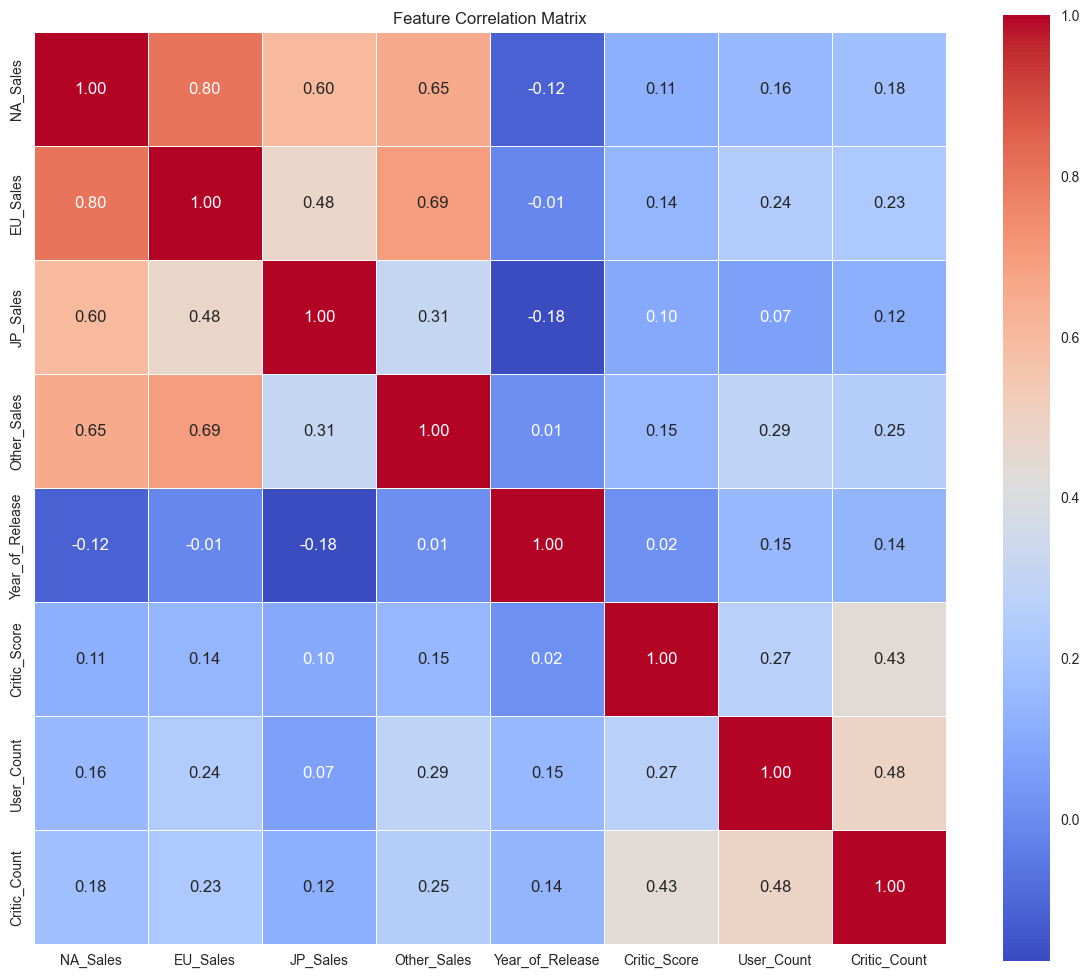

Correlation matrix plotted.


In [7]:

correlation_matrix = X_scaled.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation matrix plotted.")

Correlation with target variable:
Critic_Count       0.286527
NA_Sales           0.201877
EU_Sales           0.194914
Critic_Score       0.189379
JP_Sales           0.186597
Other_Sales        0.157485
User_Count         0.145785
Year_of_Release   -0.121358
Name: Success, dtype: float64


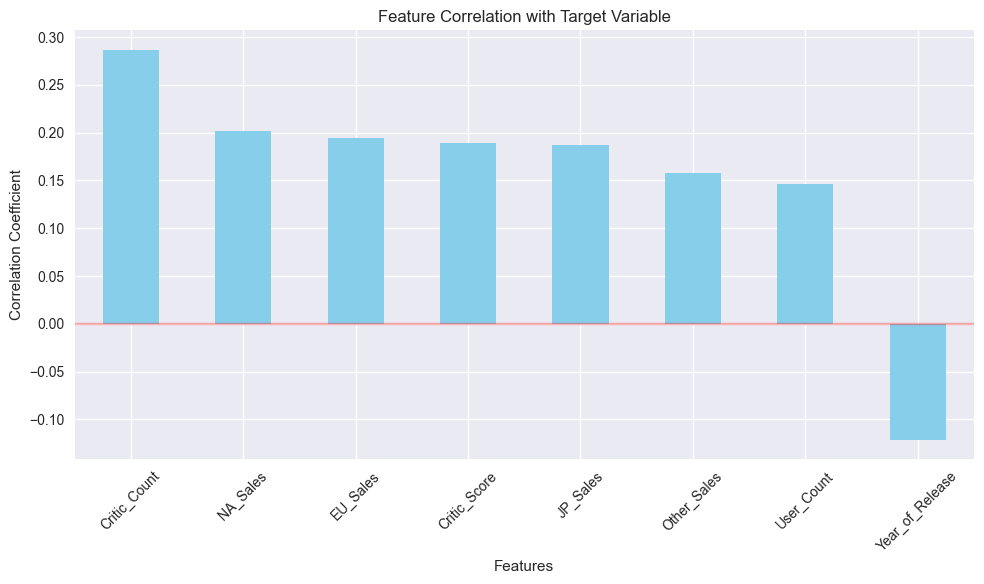

In [8]:

X_with_target = X_scaled.copy()
X_with_target['Success'] = y
target_correlation = X_with_target.corr()['Success'].sort_values(ascending=False)

print("Correlation with target variable:")
print(target_correlation.drop('Success'))


plt.figure(figsize=(10, 6))
target_correlation.drop('Success').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Feature Selection Methods

### 6.1 ANOVA F-Test

ANOVA F-Test Results:
           Feature     F_Score       p_value
7     Critic_Count  178.701911  4.224320e-39
0         NA_Sales   84.886537  7.753068e-20
1         EU_Sales   78.904731  1.419513e-18
5     Critic_Score   74.322431  1.326237e-17
2         JP_Sales   72.077238  3.973590e-17
3      Other_Sales   50.813643  1.412953e-12
6       User_Count   43.385930  5.729161e-11
4  Year_of_Release   29.865767  5.209163e-08


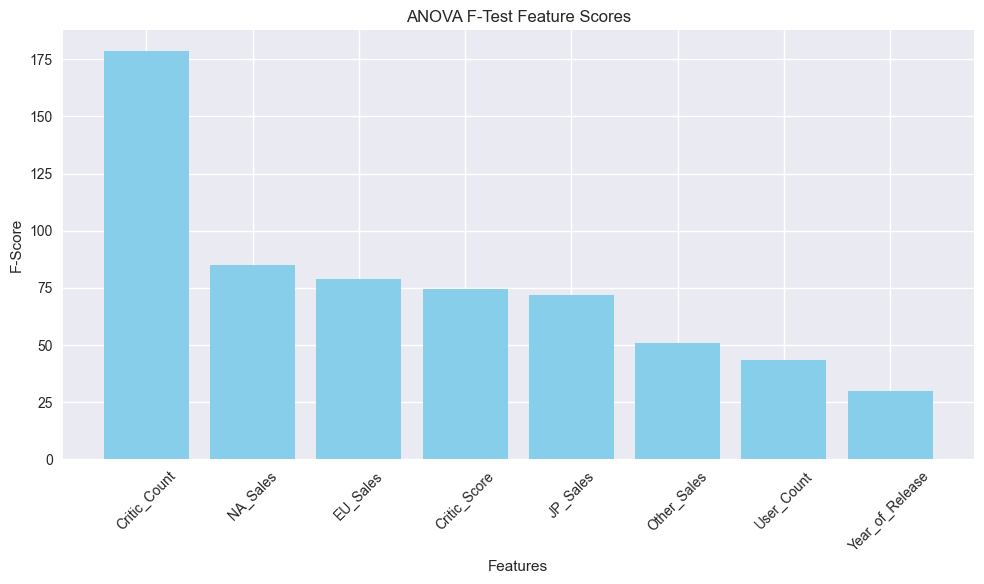

In [9]:

selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_scaled, y)

f_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'F_Score': selector_f.scores_,
    'p_value': selector_f.pvalues_
})
f_scores = f_scores.sort_values('F_Score', ascending=False)

print("ANOVA F-Test Results:")
print(f_scores)


plt.figure(figsize=(10, 6))
plt.bar(f_scores['Feature'], f_scores['F_Score'], color='skyblue')
plt.title('ANOVA F-Test Feature Scores')
plt.xlabel('Features')
plt.ylabel('F-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.2 Mutual Information

Mutual Information Results:
           Feature  MI_Score
0         NA_Sales  0.375140
3      Other_Sales  0.337976
1         EU_Sales  0.277673
2         JP_Sales  0.083209
6       User_Count  0.078901
7     Critic_Count  0.060520
5     Critic_Score  0.045765
4  Year_of_Release  0.008832


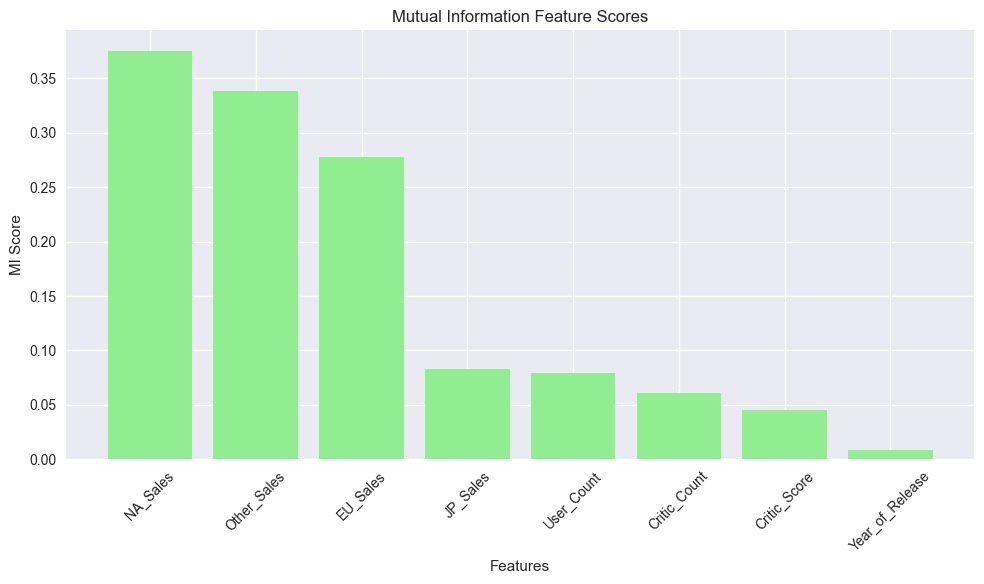

In [10]:

selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_scaled, y)

mi_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'MI_Score': selector_mi.scores_
})
mi_scores = mi_scores.sort_values('MI_Score', ascending=False)

print("Mutual Information Results:")
print(mi_scores)


plt.figure(figsize=(10, 6))
plt.bar(mi_scores['Feature'], mi_scores['MI_Score'], color='lightgreen')
plt.title('Mutual Information Feature Scores')
plt.xlabel('Features')
plt.ylabel('MI Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.3 Random Forest Feature Importance

Random Forest Feature Importance:
           Feature  Importance
0         NA_Sales    0.344712
3      Other_Sales    0.208174
1         EU_Sales    0.199042
2         JP_Sales    0.155000
6       User_Count    0.028104
4  Year_of_Release    0.025795
7     Critic_Count    0.020970
5     Critic_Score    0.018202


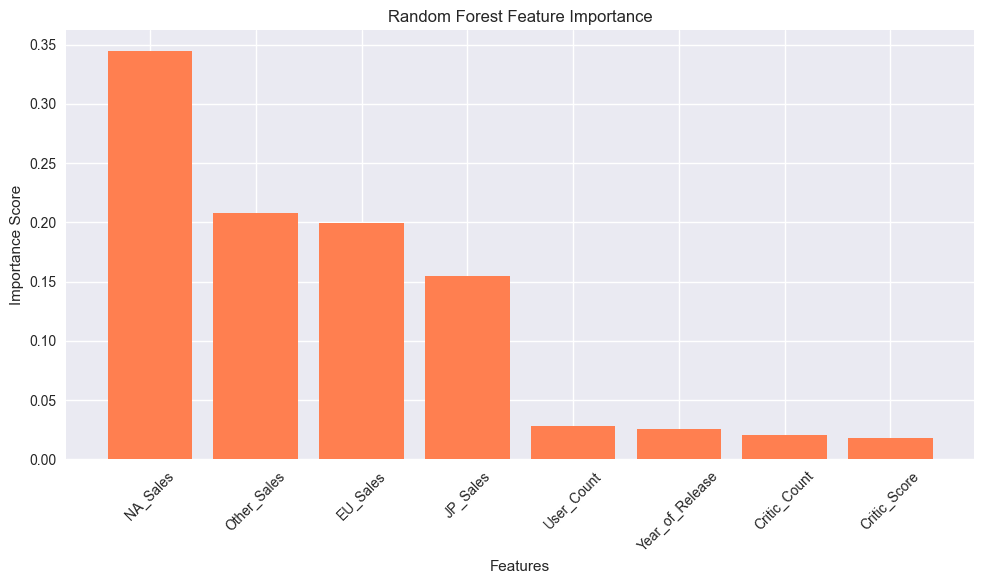

In [11]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': rf.feature_importances_
})
importances = importances.sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(importances)


plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance'], color='coral')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.4 Recursive Feature Elimination (RFE)

In [12]:

logreg = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=logreg, n_features_to_select=4)
rfe.fit(X_scaled, y)

rfe_results = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
})
rfe_results = rfe_results.sort_values('Ranking')

print("Recursive Feature Elimination Results:")
print(rfe_results)

print("\nSelected features (top 4):")
selected_features_rfe = rfe_results[rfe_results['Selected']]['Feature'].tolist()
print(selected_features_rfe)

Recursive Feature Elimination Results:
           Feature  Selected  Ranking
0         NA_Sales      True        1
1         EU_Sales      True        1
2         JP_Sales      True        1
3      Other_Sales      True        1
7     Critic_Count     False        2
4  Year_of_Release     False        3
6       User_Count     False        4
5     Critic_Score     False        5

Selected features (top 4):
['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']


## 7. Optimal Number of Features

Testing different numbers of features...


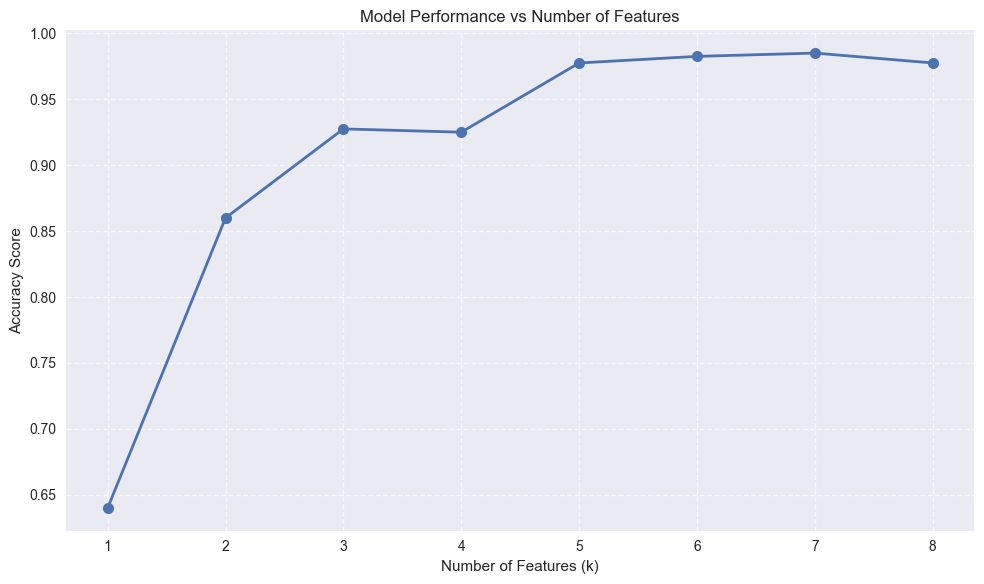


Best number of features: 7
Best accuracy: 0.9850

Selected features (7):
  - NA_Sales
  - EU_Sales
  - JP_Sales
  - Other_Sales
  - Critic_Score
  - User_Count
  - Critic_Count


In [13]:

accuracy_scores = []
k_range = range(1, len(X_scaled.columns) + 1)

print("Testing different numbers of features...")

for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_scaled, y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracy_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


best_k = k_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"\nBest number of features: {best_k}")
print(f"Best accuracy: {best_accuracy:.4f}")


selector_best = SelectKBest(score_func=f_classif, k=best_k)
selector_best.fit(X_scaled, y)
selected_features = X_scaled.columns[selector_best.get_support()]

print(f"\nSelected features ({best_k}):")
for feature in selected_features:
    print(f"  - {feature}")

## 8. Principal Component Analysis (PCA)

### 8.1 Apply PCA and Analyze Variance

In [14]:

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("PCA Explained Variance Ratios:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var:.4f} (Cumulative: {cum_var:.4f})")


min_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {min_components_95}")

PCA Explained Variance Ratios:
PC1: 0.3851 (Cumulative: 0.3851)
PC2: 0.2047 (Cumulative: 0.5898)
PC3: 0.1260 (Cumulative: 0.7159)
PC4: 0.0876 (Cumulative: 0.8034)
PC5: 0.0788 (Cumulative: 0.8822)
PC6: 0.0582 (Cumulative: 0.9404)
PC7: 0.0376 (Cumulative: 0.9780)
PC8: 0.0220 (Cumulative: 1.0000)

Components needed for 95% variance: 7


### 8.2 Scree Plot

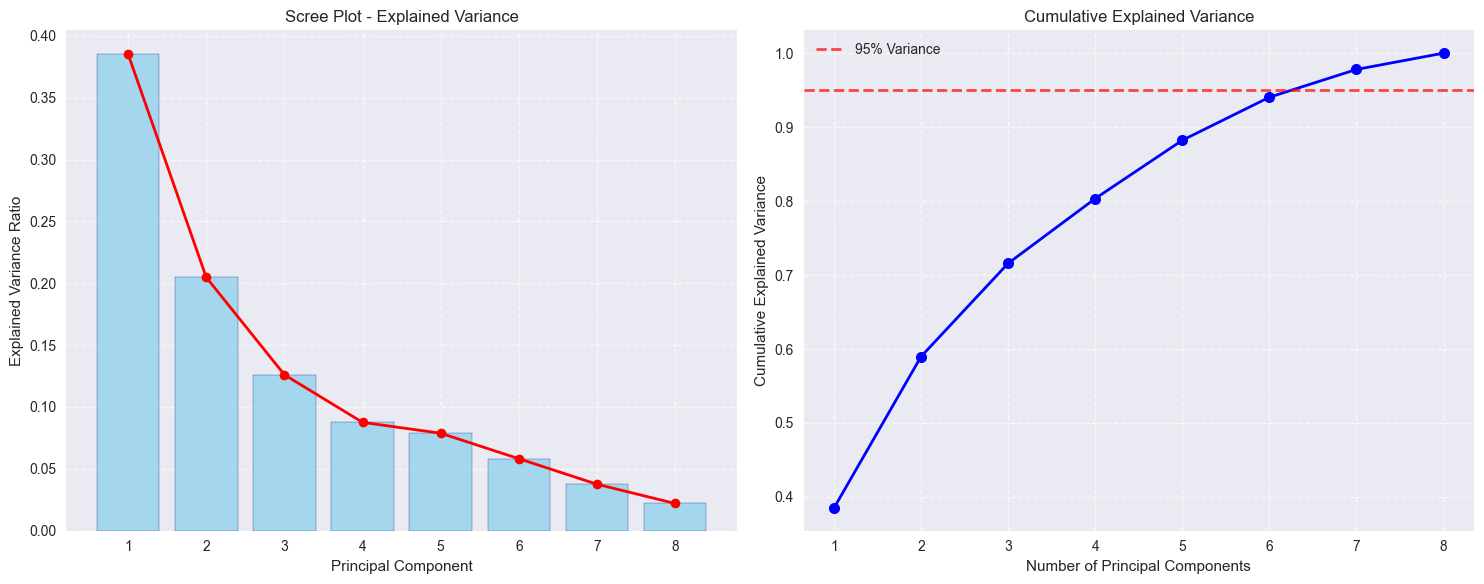

In [15]:

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, 
        alpha=0.7, color='skyblue', edgecolor='navy')
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'ro-', linewidth=2)
plt.title('Scree Plot - Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True, linestyle='--', alpha=0.7)


plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, 
           label='95% Variance', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 8.3 Feature Contributions (Loadings)

Feature Contributions to First 2 Principal Components:
                   PC1    PC2
NA_Sales         0.491 -0.263
EU_Sales         0.495 -0.163
JP_Sales         0.357 -0.291
Other_Sales      0.455 -0.057
Year_of_Release -0.022  0.370
Critic_Score     0.200  0.423
User_Count       0.255  0.479
Critic_Count     0.272  0.520


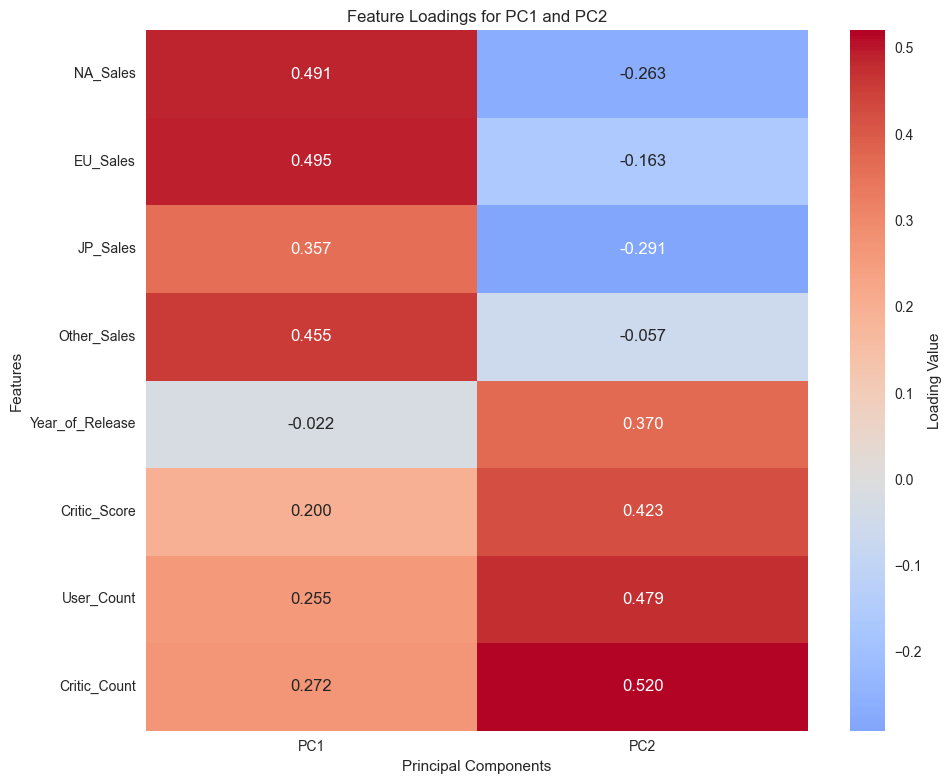

In [16]:

loadings = pca.components_
component_names = [f'PC{i+1}' for i in range(loadings.shape[0])]
loadings_df = pd.DataFrame(loadings.T, columns=component_names, index=X_scaled.columns)

print("Feature Contributions to First 2 Principal Components:")
print(loadings_df[['PC1', 'PC2']].round(3))


plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df[['PC1', 'PC2']], annot=True, cmap='coolwarm', 
            center=0, fmt='.3f', cbar_kws={'label': 'Loading Value'})
plt.title('Feature Loadings for PC1 and PC2')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### 8.4 PCA Biplot

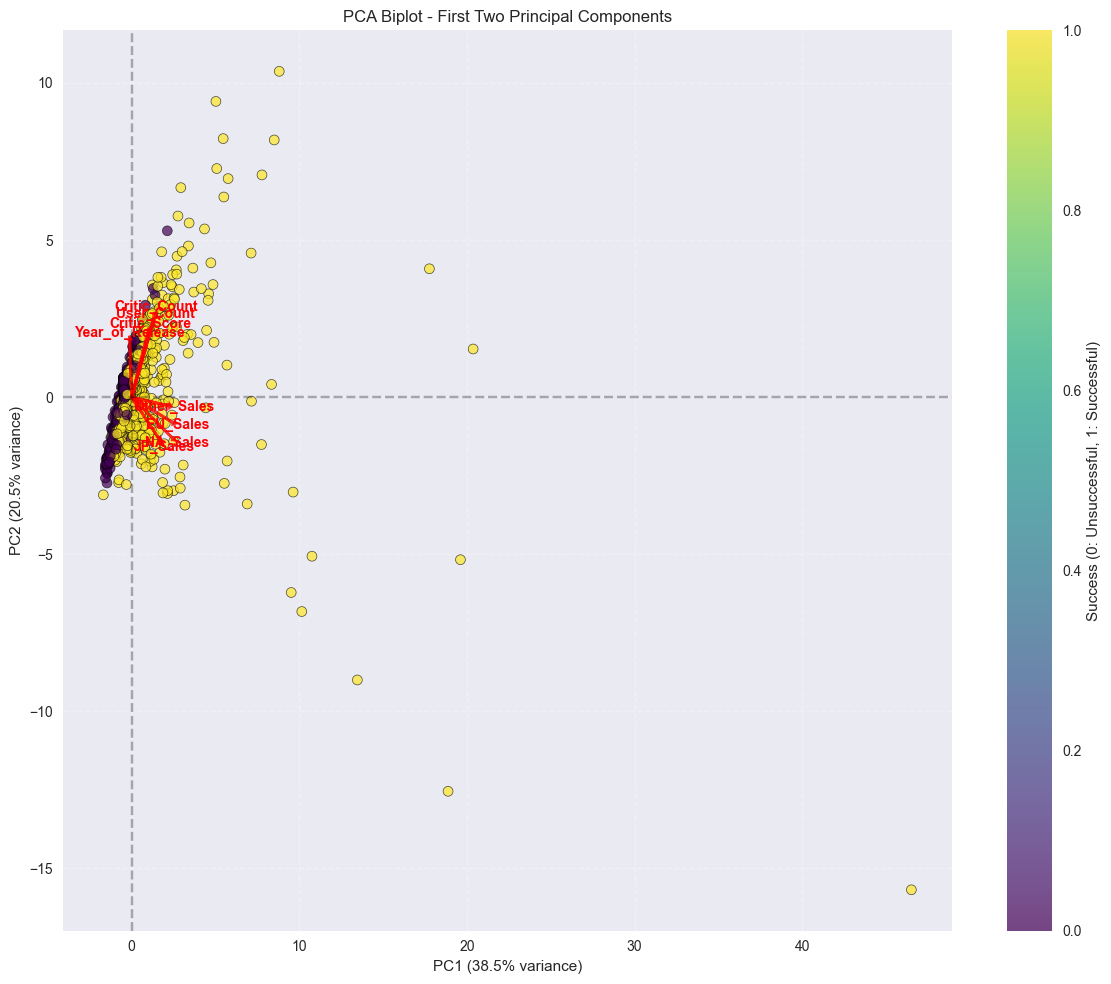

PC1 explains 38.5% of variance
PC2 explains 20.5% of variance
Together they explain 59.0% of total variance


In [17]:

plt.figure(figsize=(12, 10))


pc1_pc2 = X_pca[:, :2]
scatter = plt.scatter(pc1_pc2[:, 0], pc1_pc2[:, 1], c=y, cmap='viridis', 
                     alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Success (0: Unsuccessful, 1: Successful)')


feature_vectors_scale = 5  
for i, feature in enumerate(X_scaled.columns):
    plt.arrow(0, 0, 
             loadings[0, i] * feature_vectors_scale, 
             loadings[1, i] * feature_vectors_scale, 
             color='red', alpha=0.8, head_width=0.1, head_length=0.1, 
             linewidth=2)
    plt.text(loadings[0, i] * feature_vectors_scale * 1.1, 
            loadings[1, i] * feature_vectors_scale * 1.1, 
            feature, color='red', fontsize=10, fontweight='bold',
            ha='center', va='center')

plt.title('PCA Biplot - First Two Principal Components')
plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PC1 explains {explained_variance[0]:.1%} of variance")
print(f"PC2 explains {explained_variance[1]:.1%} of variance")
print(f"Together they explain {explained_variance[0] + explained_variance[1]:.1%} of total variance")

## 9. PCA Performance Evaluation

Testing PCA with different numbers of components...


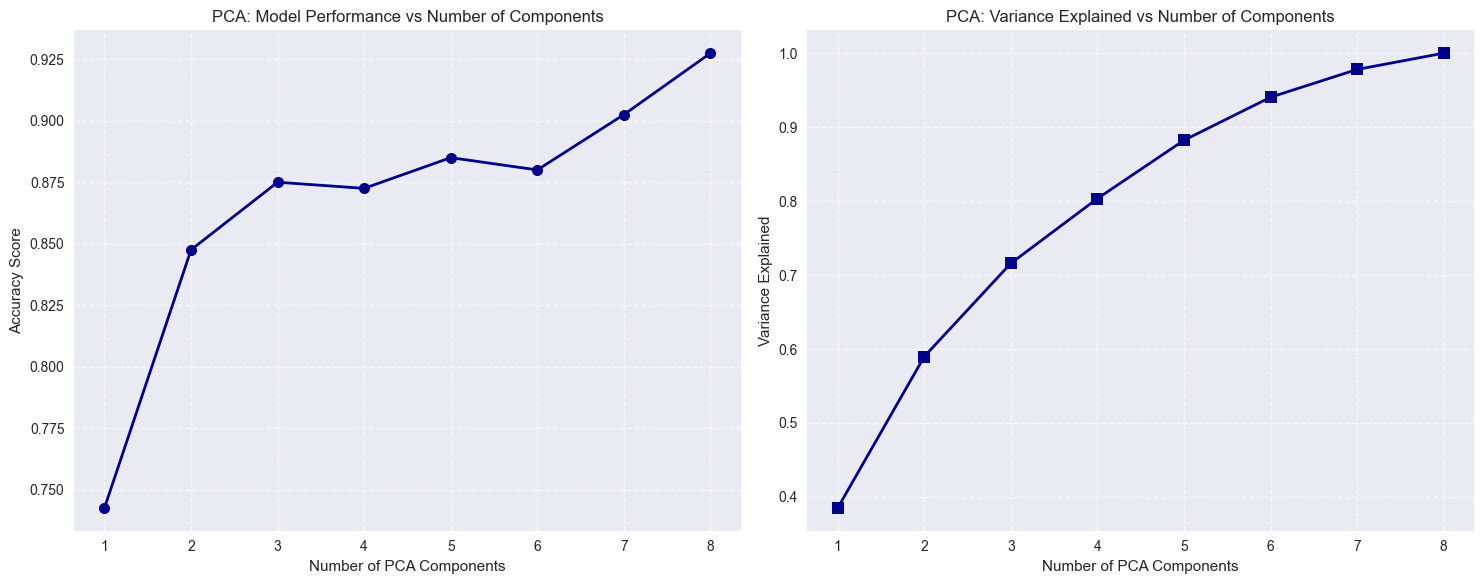

In [18]:

accuracy_scores_pca = []
variance_explained_list = []
pc_range = range(1, len(X_scaled.columns) + 1)

print("Testing PCA with different numbers of components...")

for n_components in pc_range:
   
    pca_temp = PCA(n_components=n_components)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    variance_explained_list.append(np.sum(pca_temp.explained_variance_ratio_))
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca_temp, y, test_size=0.2, random_state=42
    )
    
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores_pca.append(accuracy)


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(pc_range, accuracy_scores_pca, marker='o', linestyle='-', 
         linewidth=2, markersize=8, color='darkblue')
plt.title('PCA: Model Performance vs Number of Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(pc_range)

plt.subplot(1, 2, 2)
plt.plot(pc_range, variance_explained_list, marker='s', linestyle='-', 
         linewidth=2, markersize=8, color='darkblue')
plt.title('PCA: Variance Explained vs Number of Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance Explained')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(pc_range)

plt.tight_layout()
plt.show()